In [1]:
import numpy as np
import keras
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import scipy.io

import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
HANDS_DATASET = '../data/original/hand_dataset'

IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VALIDATION_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')

IMAGE_SHAPE=(200, 200, 3)

In [3]:
conv_base = load_model('../data/models/2018-10-09 20:54:49___0.940677957009461.h5')

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [5]:
# Create new model
# Get input
new_input = conv_base.input
# Find the layer to connect
hidden_layer = conv_base.layers[-2].output
# Connect a new layer on it
new_output = Dense(2) (hidden_layer)
# Build a new model
model = Model(new_input, new_output)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
__________

## TODO:

- Load all annotations
- Create histogram/table of how how many hands are typically in an image
- Take only a subset of the hands
- Draw the square around image
- Make sure they line up

In [7]:
def load_annotations(file):
    f = scipy.io.loadmat(file)
    #print(f.keys())
    #print(f['boxes'])
    #print(f)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations

load_annotations('/Users/kjprice/Library/Projects/smu/capstone/data/original/hand_dataset/validation_dataset/validation_data/annotations/Movie_4weds_1.mat')


[[[440.7089504683532, 307.8430372258627],
  [455.1297592090661, 316.8452744624488],
  [442.87169469293707, 336.4816380988124],
  [428.45088595222416, 327.4794008622263]],
 [[576.011464738779, 299.0238505869372],
  [562.4078900999308, 316.313811750725],
  [539.8272449386404, 298.5475779844912],
  [553.4308195774886, 281.25761682070345]],
 [[634.3091820151367, 326.80675948180374],
  [651.2069470171214, 340.89453921949485],
  [632.4972695977665, 363.33609766105326],
  [615.5995045957818, 349.24831792336215]],
 [[664.0746741852893, 326.0616568288912],
  [669.1833903308398, 309.84743408019955],
  [684.0221000082591, 314.5227587555242],
  [678.9133838627087, 330.73698150421586]],
 [[688.3921859342735, 300.1432987448546],
  [690.0271689044363, 317.0644934629375],
  [670.6723301947588, 318.93462333306735],
  [669.037347224596, 302.01342861498443]]]

In [8]:
b = load_img('../data/original/hand_dataset/training_dataset/training_data/images/Buffy_1.jpg')
b = img_to_array(b)
b.shape

(707, 618, 3)

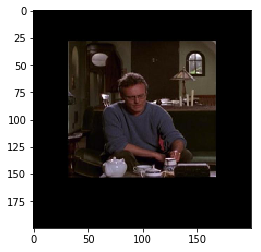

In [9]:
def load_images_as_np(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    
    images_dir = os.path.join(directory, 'images')
    images = os.listdir(images_dir)
    
    input_shape = (IMAGE_SHAPE[2], IMAGE_SHAPE[1], IMAGE_SHAPE[0])

    x_dataset = np.ndarray(shape=((len(images),) + IMAGE_SHAPE),
                     dtype=np.float32)
    
    y_dataset = []
    imgs = [] # TODO DELETE
    
    for annotation_file in annotation_files:
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        matlab_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(matlab_filepath)
        y_dataset.append(annotations)
        break

    i = 0
    for _file in images:
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        ## TODO: DELETE
        img_ORIGINAL = load_img(filepath)
        imgs.append(img_to_array(img_ORIGINAL))
        ## DELETE ABOVE
        
        # Convert to Numpy Array
        if i ==0:
            plt.imshow(img)
        x = img_to_array(img)  
        x = x.reshape((1,) + IMAGE_SHAPE)
        x_dataset[i] = x
        i += 1
        break
        if i % 250 == 0:
            print("%d images to array" % i)
            
    return imgs, y_dataset
    #return x_dataset, y_dataset
x, y = load_images_as_np(IMAGE_TRAIN_DIR)

In [10]:
first_hand_from_first_video = y[0][0]
first_image = x[0]

first_hand_from_first_video

[[345.6226103157693, 488.4295494212492],
 [348.3773896842307, 461.5704505787508],
 [387.3773896842307, 465.5704505787508],
 [384.6226103157693, 492.4295494212492]]

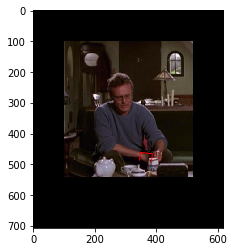

In [11]:
#ax.imshow(img)
#ax.add_patch(patches.Polygon(first_hand_from_first_video))

#points = [[2, 4], [2, 8], [4, 6], [6, 8]]
line = plt.Polygon(first_hand_from_first_video, closed=None, fill=None, edgecolor='r')
b = plt.gca()
plt.imshow(array_to_img(first_image))
b.add_patch(line)
#plt.show()

In [12]:
def display_image_with_annotations(img, annotations):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    fig.


SyntaxError: invalid syntax (<ipython-input-12-bb66ba7b1c42>, line 4)

In [ ]:
y[0][0][1]

In [ ]:


def create_data_generator():
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(
            # This is the target directory
            IMAGE_TRAIN_DIR,
            batch_size=20,)

    validation_generator = validation_datagen.flow(
            IMAGE_VALIDATION_DIR,
            batch_size=20,)
    
    return [train_generator, validation_generator]

create_data_generator()